# Test for XClone implementation with TensorFlow

For using the examples in ipynb file, you need to download the 
[G_T data](https://drive.google.com/file/d/1Yf-rR8xcs7_i3zlCZ6zQJhts2h_y_roj)
and put it in the [../data](https://github.com/huangyh09/xclone/tree/master/data) folder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

# Random seed
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
import numpy as np
from scipy.sparse import load_npz

import sys
sys.path.append("../")
from xclone.simulator import CNV_ASE_simulator

In [3]:
dat_dir = "./"
from xclone.plot import annoHeatMap

In [4]:
DP_RNA = load_npz(dat_dir + "../data/G_T/scRNA/block_DP.npz").toarray()
DP_DNA = load_npz(dat_dir + "../data/G_T/scDNA/block_DP.npz").toarray()

print(DP_RNA.shape, DP_DNA.shape)
print(DP_DNA)
print(DP_RNA)

(10152, 89) (10152, 89)
[[188. 346. 181. ...  37.  66.  58.]
 [ 43.  75.  67. ...  17.  32.  22.]
 [  1.   3.  nan ...   2.  nan  nan]
 ...
 [ 15.  10.  18. ...   2.  11.   6.]
 [  5.   4.   5. ...   1.  nan  nan]
 [ 75.  87. 149. ...  28.  39.  16.]]
[[ 6.  7. 10. ... 85. 10. 84.]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]]


In [5]:
DP_RNA[DP_RNA != DP_RNA] = 0
DP_DNA[DP_DNA != DP_DNA] = 0

### Simulation

In [6]:
n_clone = 4
n_block = 100
tau_fix = np.array([[0, 1], [1, 2], [1, 1], [2, 1], [1, 0]])
T_mat_rand = np.random.choice(range(5), size=(n_block, n_clone))

simu_dat = CNV_ASE_simulator(tau_fix, T_mat_rand, 
                             DP_RNA[:n_block, :], 
                             DP_DNA[:n_block, :],
                             share_theta=False,
                             n_cell_DNA=150, n_cell_RNA=300,
                             random_seed=2)

In [7]:
simu_dat.keys()

dict_keys(['tau', 'T_mat', 'I_RNA', 'I_DNA', 'X_RNA', 'X_DNA', 'DP_RNA', 'DP_DNA', 'AD_RNA', 'AD_DNA', 'Theta_RNA', 'Theta_DNA'])

In [8]:
# simu_dat['Theta_RNA']
simu_dat['I_DNA'].shape

(150,)

In [9]:
print(np.unique(simu_dat['I_RNA'], return_counts=True),
      np.unique(simu_dat['I_DNA'], return_counts=True))

(array([0, 1, 2, 3]), array([69, 71, 76, 84])) (array([0, 1, 2, 3]), array([31, 37, 43, 39]))


### Run ASE module with TensorFlow implementation

In [10]:
from xclone.model.XClone import XCloneVB, get_binom_coeff
np.set_printoptions(precision=4)

In [11]:
theta_prior = np.array([[0.01, 1], [1, 2], [1, 1], [2, 1], [1, 0.01]])

AD = simu_dat['AD_RNA'].astype(np.float32)
DP = simu_dat['DP_RNA'].astype(np.float32)

# AD = simu_dat['AD_DNA'].astype(np.float32)
# DP = simu_dat['DP_DNA'].astype(np.float32)

In [12]:
binom_coeff = get_binom_coeff(AD, DP)
print(binom_coeff)

[[1.3863 0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]


In [13]:
CNV_states = np.array([[0, 1], [1, 2], [1, 1], [2, 1], [1, 0]], 
                      dtype=np.float32)

model = XCloneVB(Nb = AD.shape[0], Nc=AD.shape[1], 
                 Nk=n_clone, cnv_states=CNV_states)

In [14]:
### Fix some components to reduce the inference

# _I_DNA = np.ones((150, 4), np.float32) * -2
# for i in range(150):
#     _I_DNA[i, simu_dat['I_DNA'][i]] = 2

# model.cell_logit = _I_DNA
# model.theta_s1 = (model.cnv_states[:, 0] + 0.01) * 15
# model.theta_s2 = (model.cnv_states[:, 1] + 0.01) * 15

In [15]:
model.Z.mean()[:5]

<tf.Tensor: id=101, shape=(5, 4), dtype=float32, numpy=
array([[0.2319, 0.2687, 0.2546, 0.2448],
       [0.2354, 0.2525, 0.2699, 0.2422],
       [0.2516, 0.2488, 0.2504, 0.2493],
       [0.2687, 0.255 , 0.2502, 0.2261],
       [0.241 , 0.2321, 0.2634, 0.2635]], dtype=float32)>

In [16]:
print(model.KLsum)
print(model.logLik(AD, DP, binom_coeff))

tf.Tensor(58.445934, shape=(), dtype=float32)
tf.Tensor(-88583.66, shape=(), dtype=float32)


In [17]:
## multiple learning stages with different rates
losses = tf.concat([
    model.fit(AD, DP, num_steps=100, learn_rate=0.001),
    model.fit(AD, DP, num_steps=200, learn_rate=0.02),
    model.fit(AD, DP, num_steps=500, learn_rate=0.05)], axis=-1)

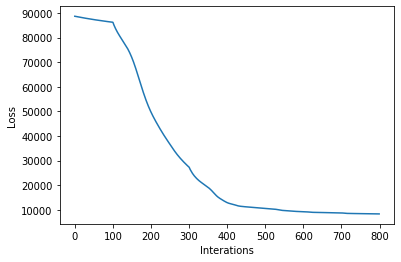

In [18]:
fig = plt.figure()
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Interations")
plt.show()

In [19]:
print(np.sum(model.Z.mean(), axis=0))
model.theta.parameters

[80.7    68.9455 77.484  72.8701]


{'concentration1': <tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=array([17.8252, 14.8084,  4.8755,  0.1265, 15.5176], dtype=float32)>,
 'concentration0': <tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=array([ 1.9184,  0.1024, 15.6636, 15.0081,  9.057 ], dtype=float32)>,
 'validate_args': False,
 'allow_nan_stats': True,
 'name': 'Beta'}

[Text(652.0000000000001, 0.5, '150 cells'),
 Text(0.5, 69.0, 'infered clones'),
 Text(0.5, 1, 'scDNA-seq: Adj Rand Index=0.912')]

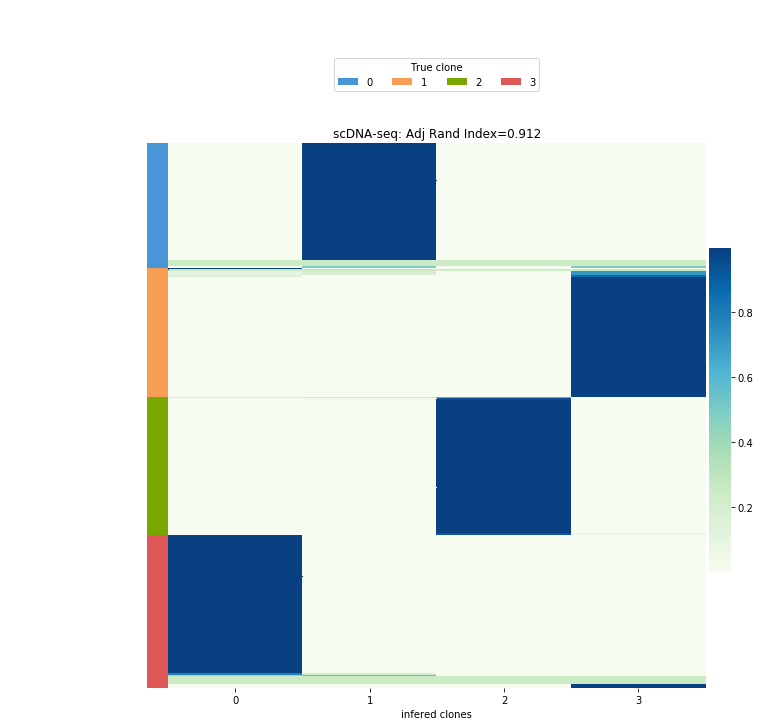

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

_ID_prob = model.Z.mean().numpy()
ARI = adjusted_rand_score(np.argmax(_ID_prob, axis=1), simu_dat['I_RNA'])

im = annoHeatMap(_ID_prob, np.array(simu_dat['I_RNA'], int), 
                 cax_pos=[.99, .2, .03, .45])

im.ax_heatmap.set(xlabel='infered clones', 
                  ylabel='150 cells',
                  title='scDNA-seq: Adj Rand Index=%.3f' %(ARI))

In [21]:
## Mean allelic ratio
np.dot(model.Y.mean(), model.theta.mean())[:5]

array([[0.0084, 0.9027, 0.0084, 0.927 ],
       [0.0084, 0.0107, 0.0084, 0.047 ],
       [0.9593, 0.5548, 0.7734, 0.5546],
       [0.9034, 0.963 , 0.9931, 0.0144],
       [0.0093, 0.9026, 0.9931, 0.0088]], dtype=float32)

### Run ASE module with vireoSNP

In [22]:
from scipy import sparse

theta_prior = np.array([[0.01, 1], [1, 2], [1, 1], [2, 1], [1, 0.01]])

AD = sparse.csr_matrix(simu_dat['AD_RNA'])
DP = sparse.csr_matrix(simu_dat['DP_RNA'])

In [23]:
DP.shape

(100, 300)

In [24]:
### with multiple initializations
## CNV block specific allelic ratio can be used by add ASE_mode=True

import vireoSNP
res = vireoSNP.vireo_flock(AD, DP, n_donor=4, learn_GT=True,
                           n_extra_donor=0, #ASE_mode=True,
                           theta_prior=theta_prior, learn_theta=True, 
                           n_init=50, check_doublet=False, random_seed=1)

print("Output donor size:", res['ID_prob'].sum(axis=0))

[vireo] warm-up: 50 random initializations for 4 clusters...
donor1	donor3	donor2	donor0
83	71	77	69
[vireo] warm-up: lower bound ranges [-37414.4, -21930.1, -21853.2]
[vireo] main RUN with warm initials and tuned GT ...
[vireo] main RUN: 22 iterations; lower bound -21930.1
[vireo] beta parameters for binomial rate:
[[39.5 43065.6]
 [3467.1 14318.5]
 [2914.9 3480.5]
 [14479.5 3516.0]
 [34034.0 65.5]]
Output donor size: [82.6 70.8 77.3 69.2]


<Figure size 288x360 with 0 Axes>

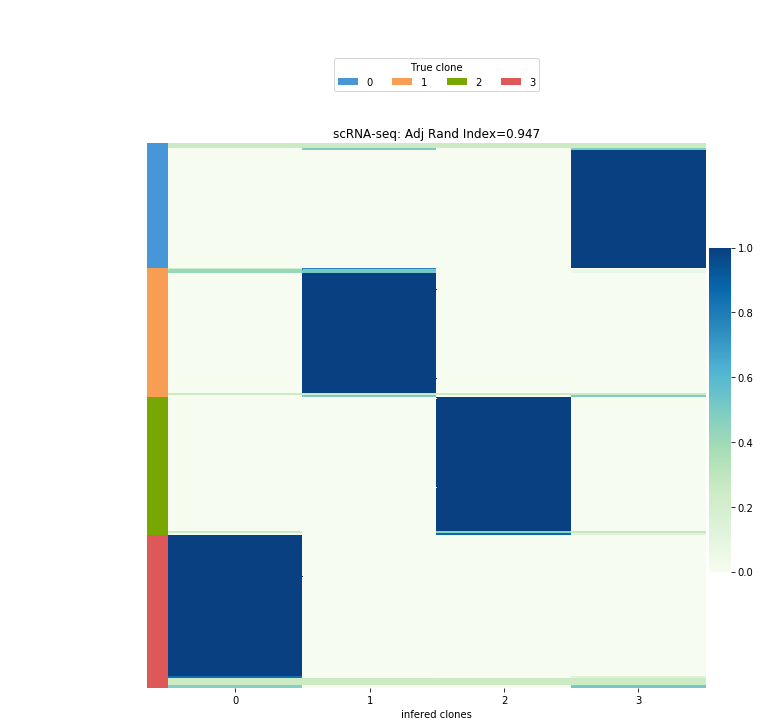

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

ARI = adjusted_rand_score(np.argmax(res['ID_prob'], axis=1), simu_dat['I_RNA'])

fig = plt.figure(figsize=(4, 5))
im = annoHeatMap(res['ID_prob'], np.array(simu_dat['I_RNA'], int))
im.ax_heatmap.set(xlabel='infered clones', 
                  ylabel='150 cells',
                  title='scRNA-seq: Adj Rand Index=%.3f' %(ARI))
plt.show()

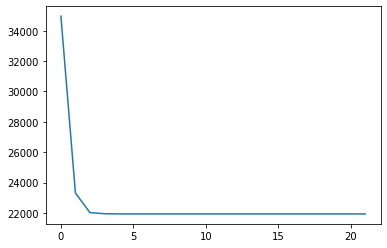

In [26]:
plt.plot(-res['LB_list'])
plt.show()

In [27]:
AF_mean = res['theta_shapes'][:, 0] / np.sum(res['theta_shapes'], axis=1)
AF_SNPs = np.tensordot(res['GT_prob'], AF_mean, axes=[1, 0])

In [28]:
AF_SNPs[:5, :]

array([[0.0, 1.0, 0.0, 0.8],
       [0.0, 0.1, 0.0, 0.0],
       [1.0, 0.5, 0.8, 0.5],
       [1.0, 0.0, 1.0, 1.0],
       [0.0, 0.0, 1.0, 1.0]])

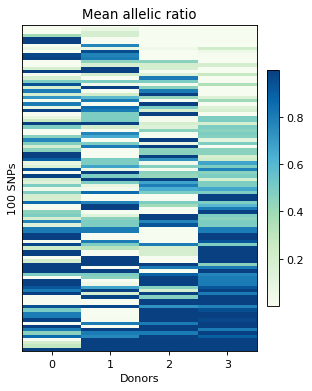

In [29]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(4, 5), dpi=80)
im = heat_matrix(AF_SNPs, cmap="GnBu", alpha=1,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Donors")
plt.ylabel("%d SNPs" %(AF_SNPs.shape[0]))
plt.yticks([])
plt.xticks([0, 1, 2, 3])

plt.tight_layout()
plt.show()